## Import all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from itertools import chain

import spacy

data_folder = 'data/'

# Table of contents
1. [Load CMU Movie Summary Corpus data](#loadCMU)
2. [Data exploration of the movie metadata](#movie)
    1. [Sub paragraph](#subparagraph1)
3. [Data exploration of the character metadata](#character)
4. [Data exploration of summaries](#summary)
5. [Summaries analysis pipeline](#pipeline)

Blabla introduce what we are doing here 

# Load CMU Movie Summary Corpus <a name="loadCMU"></a>

## Movies Metadata

In [2]:
#Load data and set indexes
movie_metadata = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movie_metadata.columns = ['movie_ID','FB_ID','movie_name','release_date','box_office','length','languages','country','genres']

#Force float type to the movie ID column, set as index
movie_metadata.movie_ID = movie_metadata.movie_ID.astype(int)
movie_metadata = movie_metadata.set_index('movie_ID')

#Drop freebase database ID, we don't need it
movie_metadata = movie_metadata.drop(columns=['FB_ID'])

#Remove movies with non-defined release date
#Convert release date to datetime type, only keep year 
movie_metadata = movie_metadata[movie_metadata.release_date.notna()]
movie_metadata['release_date'] = movie_metadata.release_date.apply(lambda d:datetime.strptime(str(d[0:4]), "%Y"))
movie_metadata['release_date'] = [date.year for date in movie_metadata.release_date]

#Change release date 1010, it's a mistake movie actually release in 2010
movie_metadata = movie_metadata.replace(1010,2010)

#Clean languages, country, genres columns
movie_metadata['languages'] = [lang.split('"')[3::4] for lang in movie_metadata.languages]
movie_metadata['country'] = [lang.split('"')[3::4] for lang in movie_metadata.country]
movie_metadata['genres'] = [lang.split('"')[3::4] for lang in movie_metadata.genres]

movie_metadata.head(10)

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
18998739,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]"
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
9997961,Contigo y aquí,1974,NaN,NaN,[Spanish Language],[Argentina],"[Musical, Drama, Comedy]"


## Characters metadata

In [3]:
#Load character metadata
character_metadata = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header=None)

#only keep movie_ID , name, gender, and age
character_metadata = character_metadata.iloc[:,[0,3,5,9]] 
character_metadata.columns = ['movie_ID','name','gender','age']
character_metadata.name = character_metadata['name'].astype(str)
character_metadata.movie_ID = character_metadata['movie_ID'].astype(int)
character_metadata = character_metadata.set_index('movie_ID')

#Drop the characters without gender defined
character_metadata = character_metadata[character_metadata.gender.notna()]

character_metadata.head(10)

,name,gender,age
movie_ID,,,
975900,Akooshay,F,42.0
975900,Lieutenant Melanie Ballard,F,27.0
975900,Desolation Williams,M,32.0
975900,Sgt Jericho Butler,M,33.0
975900,Bashira Kincaid,F,23.0
975900,Commander Helena Braddock,F,52.0
975900,Whitlock,F,56.0
975900,Big Daddy Mars,M,NaN
975900,Michael Descanso,M,30.0


## Plot summaries

In [4]:
summary_file = open(data_folder + 'plot_summaries.txt', 'r', encoding="utf8")
summaries = summary_file.readlines()

#Separate summary and movie ID
summaries = pd.DataFrame([summ.split("\t") for summ in summaries], columns=['movie_ID','summary'])
summaries['summary'] = summaries.summary.replace(r'\n',' ', regex=True) #Remove /n at end of summaries
summaries['movie_ID'] = summaries['movie_ID'].astype(int)
summaries = summaries.set_index('movie_ID')

#Count number of words in each summary
def count_words_simple(x):
    return len(x.split(" "))

summaries['length'] = summaries['summary'].apply(count_words_simple)

summaries.head()

,summary,length
movie_ID,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",26
31186339,The nation of Panem consists of a wealthy Capi...,781
20663735,Poovalli Induchoodan is sentenced for six yea...,505
2231378,"The Lemon Drop Kid , a New York City swindler,...",854
595909,Seventh-day Adventist Church pastor Michael Ch...,398


# Data exploration of the movie metadata <a name="movie"></a>

## Distibution of release data

## Which movie genres are the most frequent in the dataset?

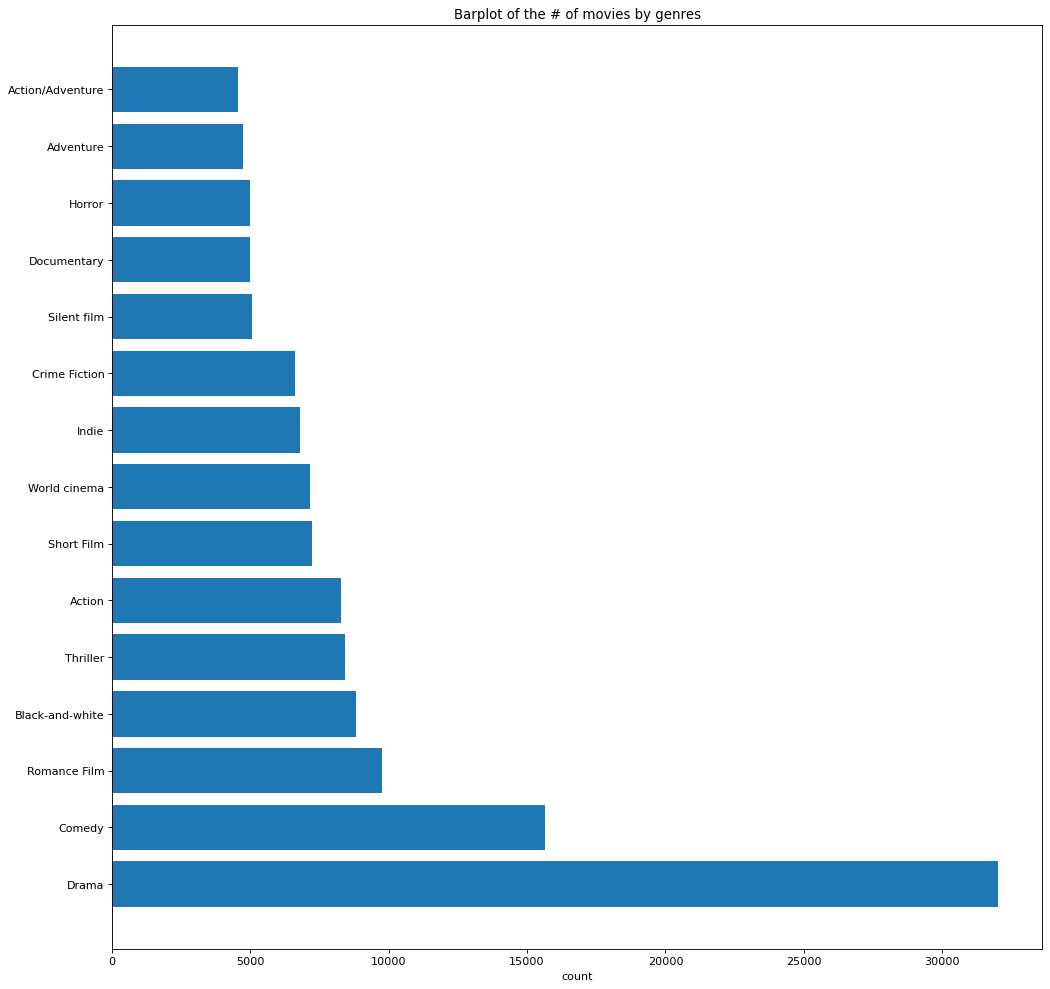

In [17]:
#Let's look at the genres of the movies
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

count_genre = get_count_genre(movie_metadata.genres)

#Let's only look at the top 15 genres
plt.figure(figsize=(15, 15), dpi=80)
plt.barh(count_genre.iloc[0:15].genre, count_genre.iloc[0:15]['count'])
plt.xlabel('count'); plt.title('Barplot of the # of movies by genres')
plt.show()

## Is the distribution the same accross decades

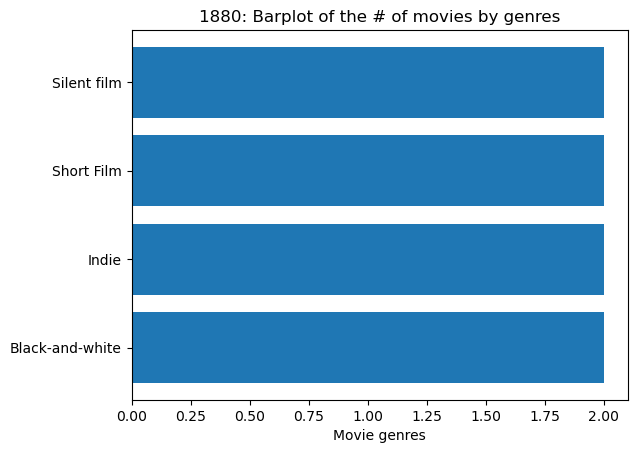

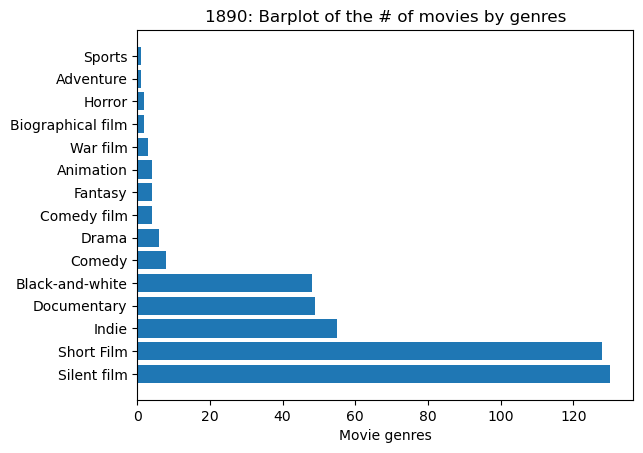

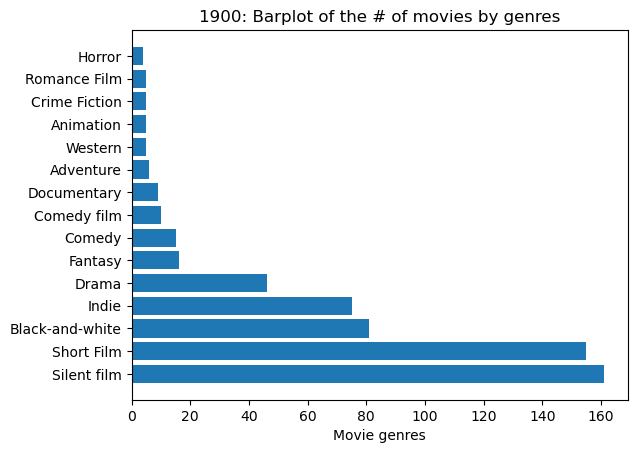

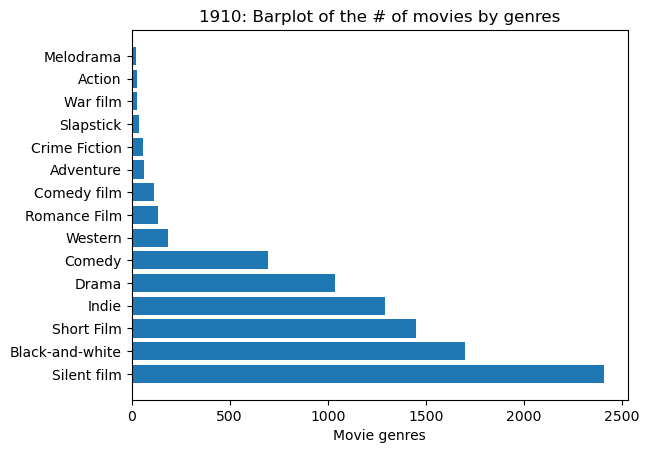

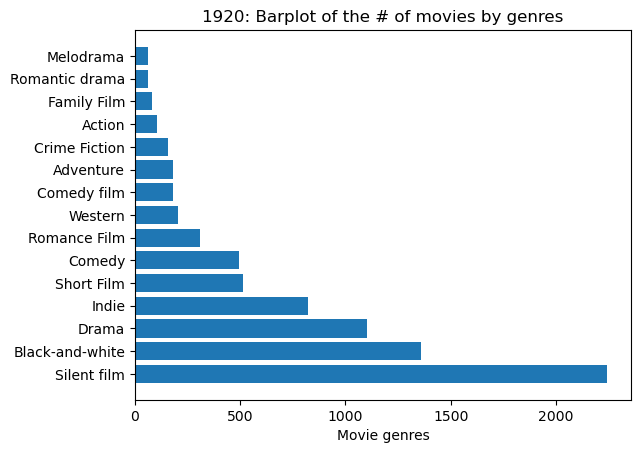

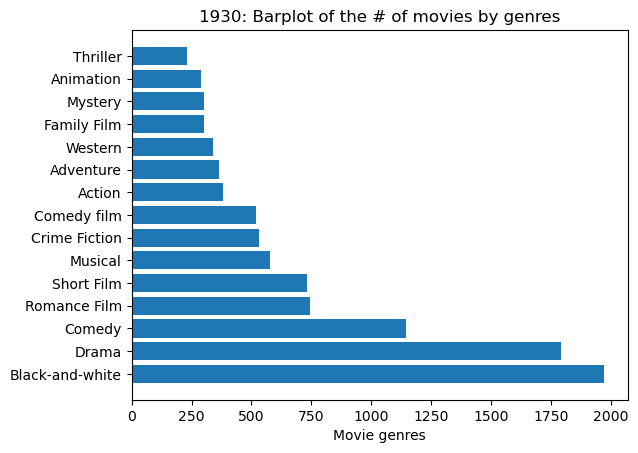

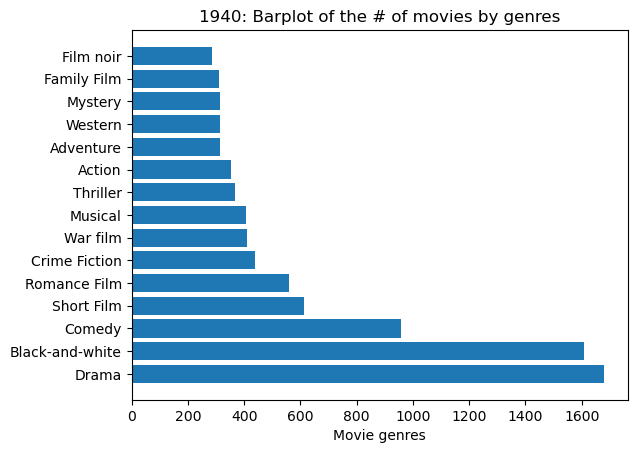

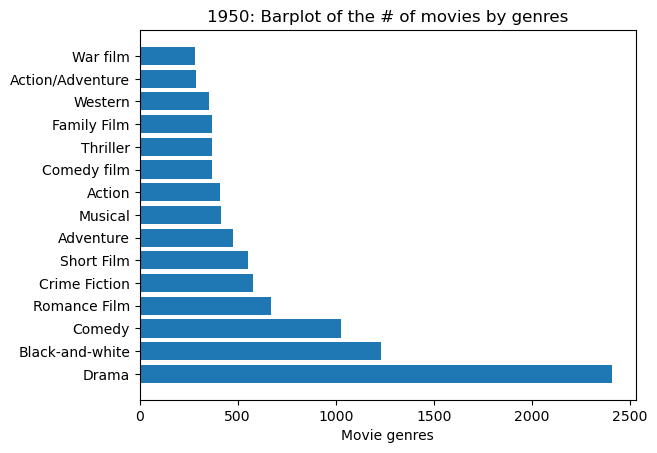

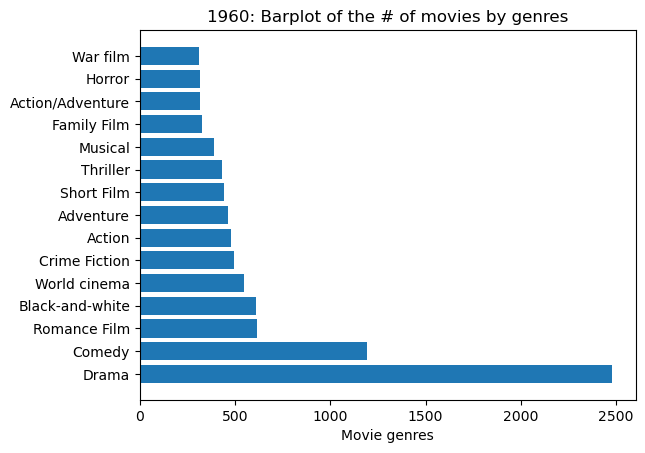

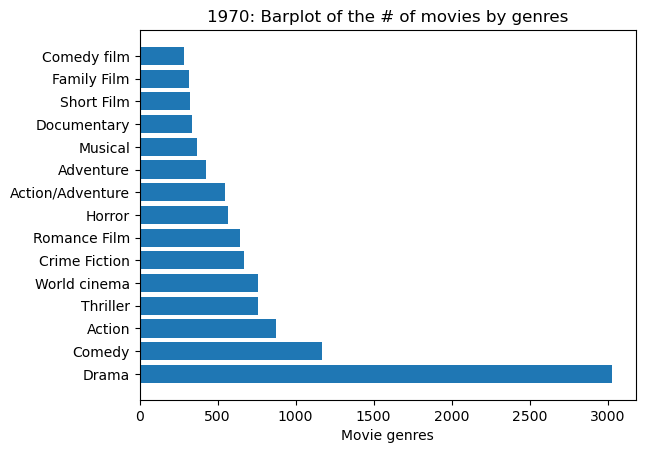

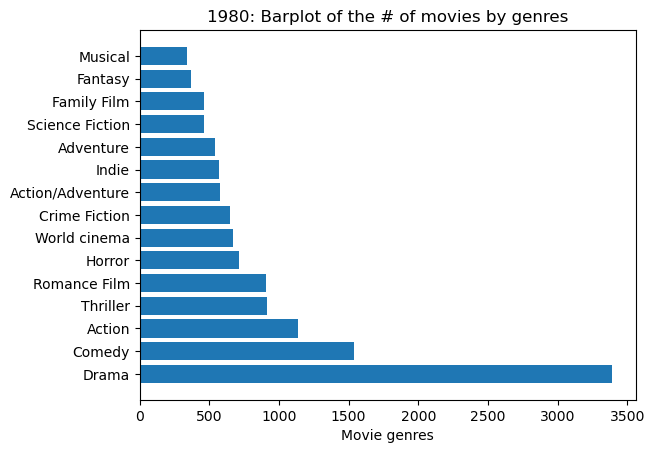

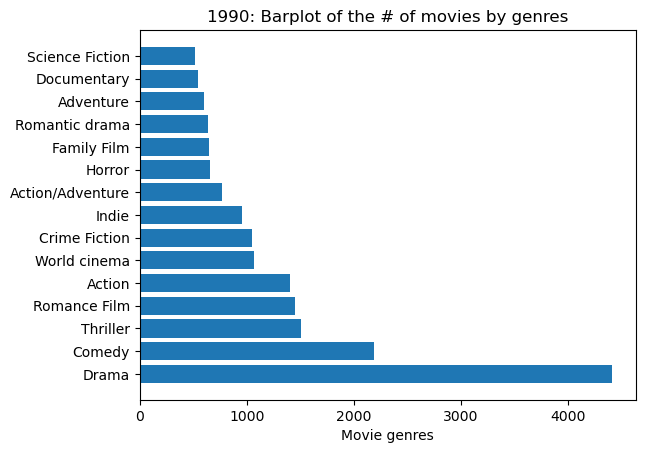

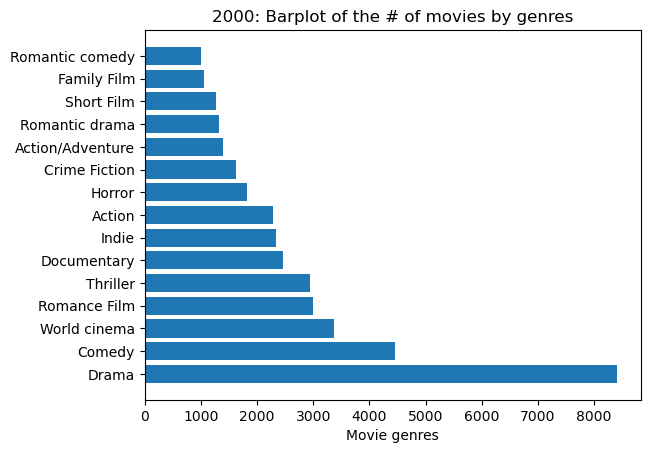

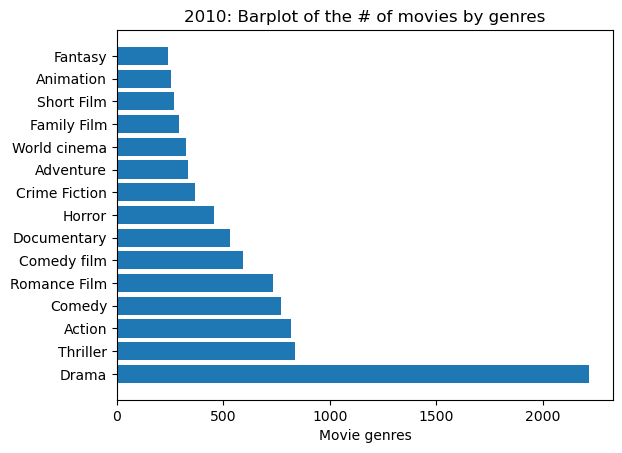

In [23]:
#Get count by decades
genre_count = movie_metadata.groupby((movie_metadata.release_date//10)*10).genres.apply(get_count_genre)

#Plot for each decade
for decade in np.unique(movie_metadata.release_date//10*10):
    
    if (genre_count.loc[decade].shape[0] >= 15):
        plt.barh(genre_count.loc[decade]['genre'].iloc[0:15], genre_count.loc[decade]['count'].iloc[0:15])
    else:
        plt.barh(genre_count.loc[decade]['genre'].values, genre_count.loc[decade]['count'])
    
    plt.xlabel('Movie genres'); plt.title(str(decade) + ': Barplot of the # of movies by genres')
    plt.show()

## Where were produced the movies?

The movies in the corpus were produced in a lot of different countries. However, the vast majority are from the US.

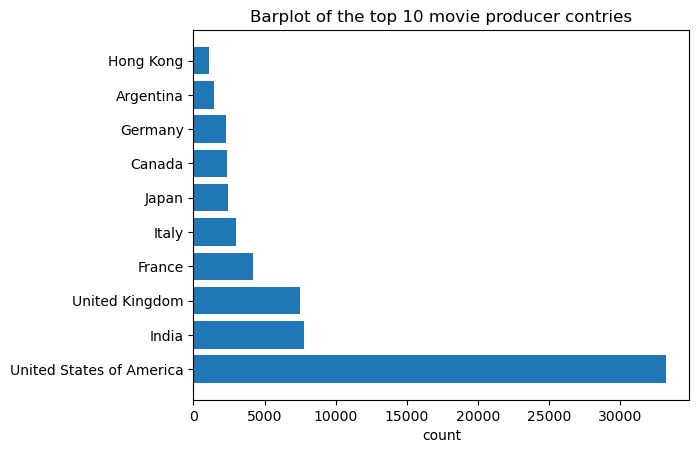

In [13]:
#Count for each country
country, count_country =  np.unique((list(chain.from_iterable(movie_metadata.country))),return_counts=True)
count_country = pd.DataFrame(count_country, index = country, columns=['count'])
count_country = count_country.sort_values(by=['count'], ascending=False)

#Let's only look at the top 10 producing movie country
plt.barh(count_country.iloc[0:10].index, np.squeeze(count_country.iloc[0:10].values))
plt.xlabel('count'); plt.title('Barplot of the top 10 movie producer contries')
plt.show()

## Select only USA produced movies

In [24]:
def check_USA_produced(countries):
    return any('United States of America' in country for country in countries)

#Select only movies produced in the US
mask_usa = [check_USA_produced(x) for x in movie_metadata.country]
usa_movie = movie_metadata[mask_usa]

usa_movie.head()

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
175026,Sarah and Son,1930,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"


# Data exploration summaries <a name="summary"></a>

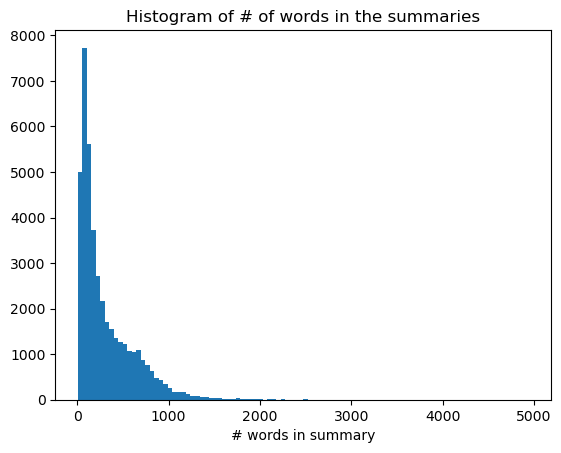

In [26]:
#Let's look at the distibution of the length of the summaries
plt.hist(summaries['length'],bins=100)
plt.xlabel('# words in summary'); plt.title('Histogram of # of words in the summaries')
plt.show()

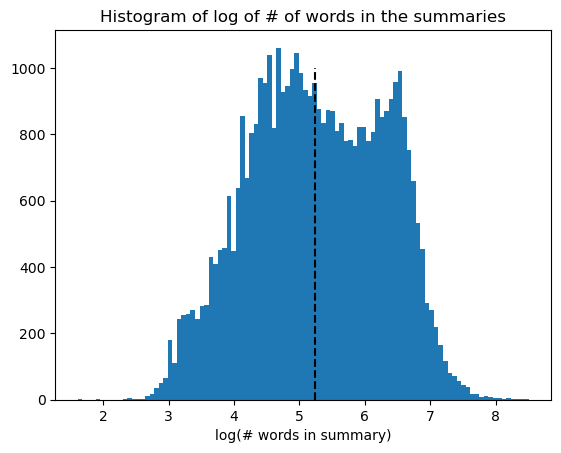

In [27]:
#The distribution is heavy tailed, apply log before binning
plt.hist(np.log(summaries['length']),bins=100)
plt.vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
plt.xlabel('log(# words in summary)'); plt.title('Histogram of log of # of words in the summaries')
plt.show()

The dashed line is the median.

In [30]:
df = usa_movie

#Filter out summaries that are not in the set of movie of interest (USA + released after ...)
movie_interest = list(set(np.unique(summaries.index)).intersection(df.index.values))
summaries = summaries.loc[movie_interest]

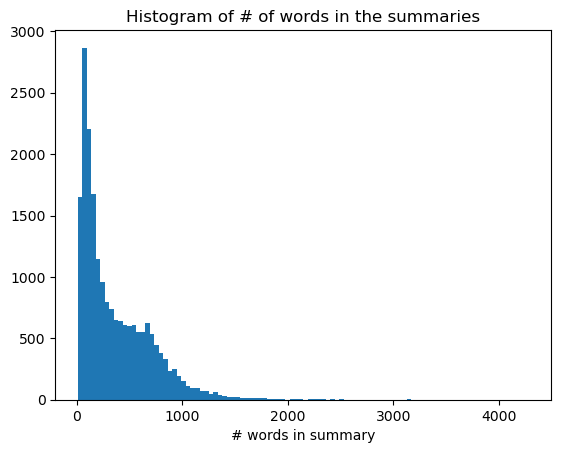

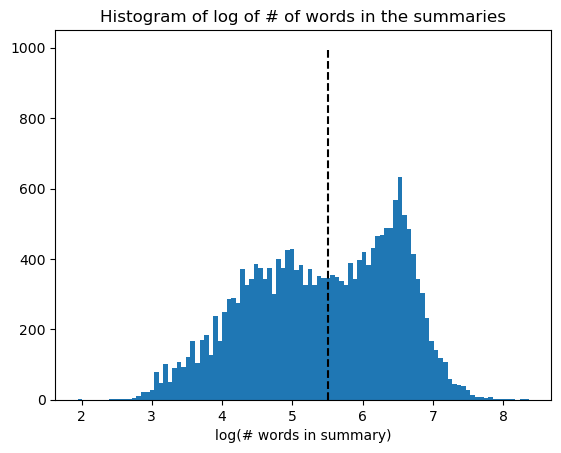

In [31]:
#Let's look at the distibution of the length of the summaries
plt.hist(summaries['length'],bins=100)
plt.xlabel('# words in summary'); plt.title('Histogram of # of words in the summaries')
plt.show()

#The distribution is heavy tailed, apply log before binning
plt.hist(np.log(summaries['length']),bins=100)
plt.vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
plt.xlabel('log(# words in summary)'); plt.title('Histogram of log of # of words in the summaries')
plt.show()

# Justify threshold for summary length by showing it's enough to extract info with pipeline.

In [32]:
summaries_new = summaries[summaries.length >= 400]
print(summaries.shape);summaries_new.shape

(20240, 2)


(7430, 2)

# Summary NLP analysis pipeline <a name="pipeline"></a>